# Using NCrystal as a backend for full-fledged Monte Carlo simulations

In this notebook we discuss how the full potential of NCrystal is realised when used as a physics engine for applications which track neutrons as they traverse complicated geometries and undergo multiple scatterings in complex geometries.  In particular we will mention how NCrystal is used in applications like McStas, OpenMC, or Geant4. Additionally, we will show how NCrystal's own builtin "MiniMC" framework can be used to quickly get scattering patterns from NCrystal materials in simple geometries.

## Preamble
Fix dependencies and tune jupyter a bit. Feel free to replace as you wish:

In [2]:
#Optionally install dependencies via pip. The default is to do this only
#on Google Colab, but you can modify the next line to do it always:
always_do_pip_installs = False # Set to True to enable outside Google Colab
import os
if always_do_pip_installs or os.environ.get("COLAB_RELEASE_TAG"):
    %pip -q install ncrystal ipympl numpy matplotlib

In [3]:
#enable inline matplotlib plots:
if os.environ.get("COLAB_RELEASE_TAG"):
  print("Google Colab detected, matplotlib plots will not be interactive")
  %matplotlib inline
  import matplotlib
  matplotlib.rcParams.update({"figure.autolayout": True})
else:
  print("Enabling interactive matplotlib plots (requires ipympl installed)")
  %matplotlib ipympl
  import matplotlib
  matplotlib.rcParams.update({"figure.figsize":(6.4*0.5,4.8*0.5),
                              "figure.dpi":150,
                              'font.size':5,
                              "figure.autolayout": True})

Enabling interactive matplotlib plots (requires ipympl installed)


In [4]:
%%html
<style>div.jupyter-widgets.widget-label {display: none;}</style>

Always import NCrystal of course:

In [5]:
import NCrystal as NC
assert NC.version_num >=  3009004
NC.test() #< quick unit test that installation works!

Tests completed succesfully


## Estimating multiple scattering effects with NCrystal's MiniMC
Effects of geometry and multiple scattering is normally something that appears when NCrystal is used with a suitable frontend like McStas, OpenMC, or Geant4. The frontend application keeps track of neutron trajectories and fluxes as they propagate around in a particular geometry. However, NCrystal 3.9.0 introduced a small "MiniMC" frontend, in which neutrons are propagated through a single convex volume (for now just a sphere), and recorded as they come out. For now, the only source available is a monochromatic pencil beam and the only tally available is a 4pi detector showing the exit angle w.r.t. the incoming angle.

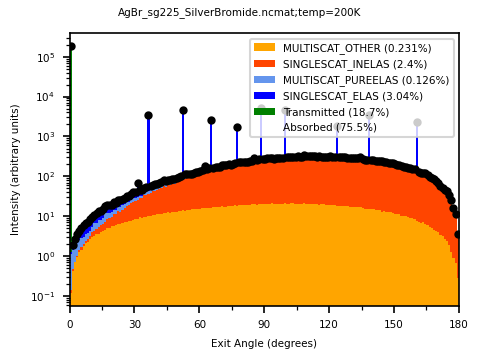

In [11]:
import NCrystal._mmc as ncmmc
pattern = ncmmc.quick_diffraction_pattern('AgBr_sg225_SilverBromide.ncmat;temp=200K',
                                           neutron_energy = '1.8Aa',
                                           material_thickness = '1cm')

pattern.plot_breakdown(rebin_factor=10,logy=True)

Note that you can get this plot same in the terminal by running:
```
nctool --mc 1.8Aa 1cm 'AgBr_sg225_SilverBromide.ncmat;temp=200K'
```
We can try a few more patterns for fun, including some single crystals:

In [12]:
def show_mmc(cfgstr,e,t,log=True):
    pattern = ncmmc.quick_diffraction_pattern( cfgstr, neutron_energy = e, material_thickness = t )
    pattern.plot_breakdown(rebin_factor=10,logy=log)

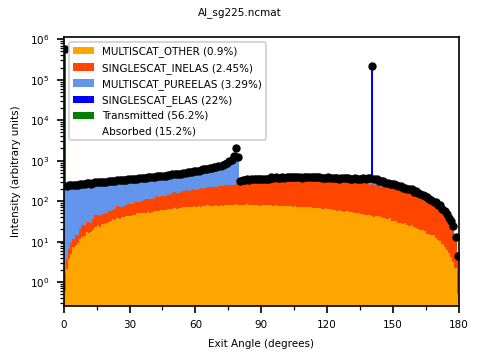

In [13]:
show_mmc('Al_sg225.ncmat','4.4Aa','5cm')#single Bragg edge here

NCrystal WARNING: Discarding 52 edges of provided kernel data due to missing S values.


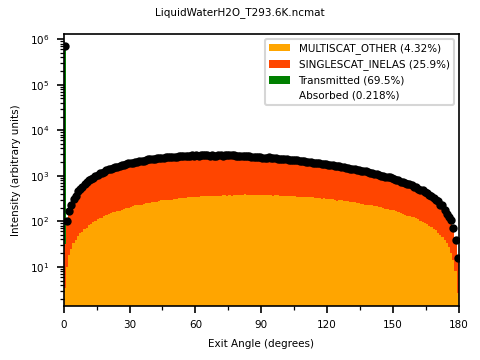

In [14]:
show_mmc('LiquidWaterH2O_T293.6K.ncmat','25meV','1mm')

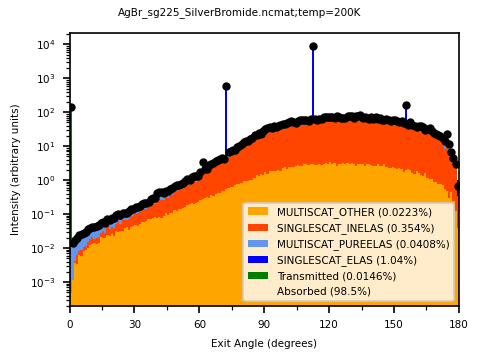

In [15]:
show_mmc('AgBr_sg225_SilverBromide.ncmat;temp=200K','3.4Aa','3cm')#absorbing, suppressing fwd transmission

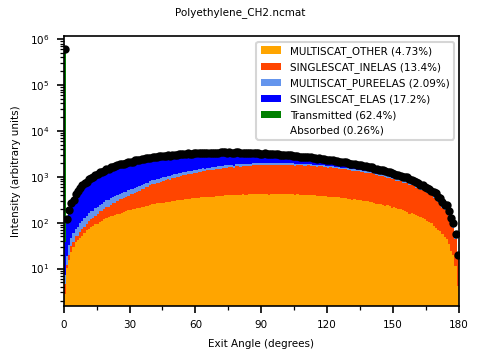

In [16]:
show_mmc('Polyethylene_CH2.ncmat','25meV','1mm')#incoherent elastic is emitted mostly forward

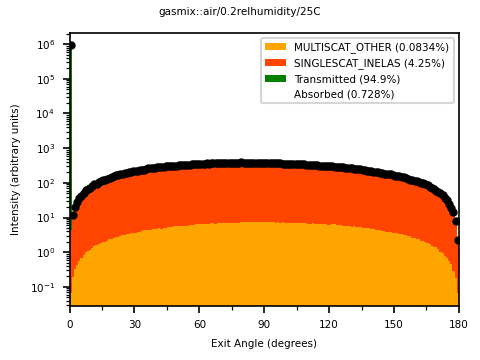

In [17]:
show_mmc('gasmix::air/0.2relhumidity/25C','25meV','1meter')

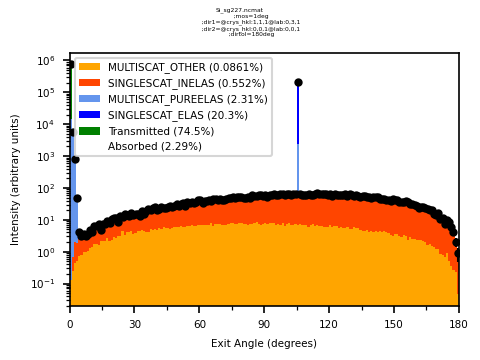

In [18]:
show_mmc('''Si_sg227.ncmat
            ;mos=1deg
            ;dir1=@crys_hkl:1,1,1@lab:0,3,1
            ;dir2=@crys_hkl:0,0,1@lab:0,0,1
            ;dirtol=180deg''','5.0Aa','1cm')#notice zig-zag walk enhances transmission and reflected peaks

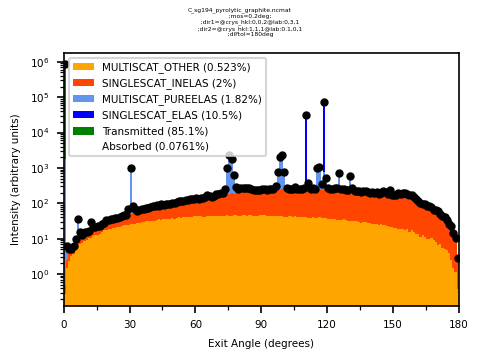

In [19]:
show_mmc('''C_sg194_pyrolytic_graphite.ncmat
           ;mos=0.2deg;
           ;dir1=@crys_hkl:0,0,2@lab:0,3,1
           ;dir2=@crys_hkl:1,1,1@lab:0.1,0,1
           ;dirtol=180deg''','3.5Aa','1cm')

## Using NCrystal with other codes.
Although not directly related to the Python API of NCrystal, we anyway take the opportunity to provide a small overview of some of the frontends that you can currently use with NCrystal. This is after all in all likelihood the primary reason most NCrystal users care about NCrystal.

### OpenMC
Using NCrystal materials in openmc is supported since OpenMC release 13.3, and uses a nice simple syntax in the Python API (see also https://docs.openmc.org/en/stable/usersguide/materials.html#adding-ncrystal-materials):

```python
mat = openmc.Material.from_ncrystal('Polyethylene_CH2.ncmat;temp=50C')
```

which when used in a complete OpenMC project, results in the following material entry being added to the `materials.xml` produced:

```xml
  <material cfg="Polyethylene_CH2.ncmat;temp=50C" id="1" temperature="323.15">
    <density units="g/cm3" value="0.92" />
    <nuclide ao="0.66656284" name="H1" />
    <nuclide ao="0.00010382666666666666" name="H2" />
    <nuclide ao="0.32964066666666664" name="C12" />
    <nuclide ao="0.003692666666666666" name="C13" />
  </material>
```

Temperature, density and material composition were all created automatically from the cfg-string, and the cfg-string itself was also encoded. Upon launching the simulation with the OpenMC binary executable `openmc`, it will handle the material as usual, except that low-energy neutron scattering physics (currently defined as ($E<5eV$) will be provided by the algorithms in NCrystal.

A few issues might warrent attention:

1. If you try to assemble the above xml manually, it is rather unlikely that you will get the base densities and compositions right. It is safest to stick to let the Python API compose the xml for you.
2. After creation with `mat=openmc.Material.from_ncrystal(..)`, you can not use the usual OpenMC API to modify the material density, temperature, or composition. So be sure to reflect the final desired material inside the NCrystal cfg-string.
3. The OpenMC binaries must have been built with NCrystal support, or your job will fail once you launch the simulation (you can check for this by running the command `openmc -v`). Specifically (as documented on https://docs.openmc.org/en/stable/usersguide/install.html) you must supply the CMake flag
`cmake -DOPENMC_USE_NCRYSTAL=on ..` (and make sure NCrystal is available already).
Note: we have agreement from OpenMC developers to enable NCrystal support by default in the conda-forge version of OpenMC. So in "the near future" (summer/fall 2023) conda users will always have NCrystal support available in OpenMC.

For reference, here is a complete small example of an OpenMC project in Python using NCrystal.

```python
    import openmc
    # Materials
    openmc_mat = openmc.Material.from_ncrystal('Polyethylene_CH2.ncmat;temp=50C')
    # Geometry
    s1 = openmc.Sphere(r=10, boundary_type='vacuum')
    c1 = openmc.Cell(region=-s1, fill=openmc_mat)
    geometry = openmc.Geometry([c1])
    # Execution settings
    settings = openmc.Settings()
    settings.source = openmc.Source(energy=openmc.stats.Discrete(x=[10.0], p=[1.0]))
    settings.run_mode = 'fixed source'
    settings.batches = 10
    settings.particles = 10000
    # Write xml files
    model = openmc.model.Model(geometry=geometry, settings=settings)
    model.export_to_xml()
    #Check resulting materials.xml (we could of course actually RUN OpenMC here instead)
    import pathlib
    print(pathlib.Path('materials.xml').read_text())
```

Credits: The OpenMC-NCrystal bindings originated with the NCrystal developers (esp. J.I. Marquez Damian), but were facilitated along the way by useful technical assistance and a welcoming attitude from the OpenMC developers (esp. Paul Romano).

### McStas (incl. Union and McStasScript)

You can use NCrystal in two ways in McStas. You can either use it for advanced studies with the McStas Union sub-system through the `NCrystal_process` component, or it can be used via the dedicated (and less feature-rich) `NCrystal_sample.comp`.

It is beyond the scope for this notebook to provide a full documentation of McStas, or the Union sub-system, but if you are using McStasScript to compose your instruments, you can add NCrystal materials into your Union geometry using code like:
```python
  from mcstasscript.tools.ncrystal_union import add_ncrystal_union_material
  add_ncrystal_union_material(instr, name="myAl", cfgstr="Al_sg225.ncmat;temp=10C")
```
This creates the material and gives it the name `"myAl"`, which you must later attach to a particular Union volume, like for instance:
```python
  myvol.set_parameters(radius=0.01, yheight=0.01, material_string='"myAl"', priority=1)
```
If you are instead hand-editing your instrument files, you can generate code which defines Union materials from an NCrystal cfg-string by invoking:

In [22]:
!python3 -mNCrystal.mcstasutils --union myAl 'Al_sg225.ncmat;temp=250K'


/*
   The following code was auto generated by NCrystal v3.9.4 via Python:

     NCrystal.mcstasutils.cfgstr_2_union_instrument_code(
         cfgstr = 'Al_sg225.ncmat;temp=250K',
         name = 'myAl' )

   Please rerun in case of major changes to input data or NCrystal.
*/

COMPONENT myAl_ncrystal_proc = NCrystal_process(
    cfg = "Al_sg225.ncmat;temp=250" )
AT (0,0,0) ABSOLUTE

COMPONENT myAl = Union_make_material(
    process_string = "myAl_ncrystal_proc",
    my_absorption = 1.39136803716641 )
AT (0,0,0) ABSOLUTE

/* End of auto generated code from NCrystal v3.9.4. */



Or you can add `--split` to investigate by physics type:

In [23]:
!python3 -mNCrystal.mcstasutils --union myAl 'Al_sg225.ncmat;temp=250K' --split


/*
   The following code was auto generated by NCrystal v3.9.4 via Python:

     NCrystal.mcstasutils.cfgstr_2_union_instrument_code(
         cfgstr = 'Al_sg225.ncmat;temp=250K',
         name = 'myAl',
         split_by_physics = True )

   Please rerun in case of major changes to input data or NCrystal.
*/

COMPONENT myAl_ncrystal_cohelas_proc = NCrystal_process(
    cfg = "Al_sg225.ncmat;incoh_elas=0;inelas=0;sans=0;temp=250" )
AT (0,0,0) ABSOLUTE

COMPONENT myAl_ncrystal_incohelas_proc = NCrystal_process(
    cfg = "Al_sg225.ncmat;coh_elas=0;inelas=0;sans=0;temp=250" )
AT (0,0,0) ABSOLUTE

COMPONENT myAl_ncrystal_inelas_proc = NCrystal_process(
    cfg = "Al_sg225.ncmat;coh_elas=0;incoh_elas=0;sans=0;temp=250" )
AT (0,0,0) ABSOLUTE

COMPONENT myAl = Union_make_material(
    process_string = "myAl_ncrystal_cohelas_proc,myAl_ncrystal_incohelas_proc,myAl_ncrystal_inelas_proc",
    my_absorption = 1.39136803716641 )
AT (0,0,0) ABSOLUTE

/* End of auto generated code from NCrystal v3.

It should be noted that McStas has a `SHELL` syntax which can also be used to faciliate this invocation from with a classic `.instr` file. Its usage can bee seen in the following example

```c
DEFINE INSTRUMENT example2()
SHELL "python3 -mNCrystal.mcstasutils --union --split myMaterial_Al 'phases<0.01*void.ncmat&0.99*Al_sg225.ncmat;temp=200K>' > materials_snippet.instr"
TRACE
COMPONENT init = Union_init()
AT (0,0,0) ABSOLUTE
%include "materials_snippet.instr"
COMPONENT origin = Progress_bar()
  AT (0, 0, 0) RELATIVE ABSOLUTE
COMPONENT source =   Source_div(lambda0=1.539739, dlambda=0.01, xwidth=0.001, yheight=0.001, focus_aw=1, focus_ah=1)
  AT (0, 0, 0.3) RELATIVE origin
COMPONENT powder_sample = Union_cylinder(yheight=0.01, radius=0.01, priority=1, material_string="myMaterial_Al")
AT (0, 0, 1) RELATIVE origin
COMPONENT master2 = Union_master()
AT (0, 0, 0) RELATIVE powder_sample
COMPONENT powder_pattern_detc = Monitor_nD(
    options = "banana, angle limits=[10 170], bins=500",
    radius = 0.05, yheight = 0.1)
  AT (0, 0, 0) RELATIVE powder_sample
COMPONENT stop = Union_stop()
AT (0,0,0) ABSOLUTE
END
```

On the other hand, the dedicated NCrystal_sample.comp component, embeds NCrystal material simulations into simple shapes (currently boxes, cylinders and spheres), and can be used for components representing samples, filters or monochromators, entrance windows, etc. The component is since McStas v3.3 part of the McStas release itself, and can be used in a .instr file - for instance if you wish to set up an r=1cm sphere with powdered sapphire you would write:
```c
COMPONENT mysample = NCrystal_sample(cfg="Al2O3_sg167_Corundum.ncmat",radius=0.01)
AT (0, 0, 0) RELATIVE PREVIOUS
```
For more documentation about the NCrystal_sample component, run:
```bash
$> mcdoc NCrystal_sample
```
Or consult the documentation online at https://www.mcstas.org/download/components/

*Credits: The integration into McStas, Union, and McStasScript is largely a result of efforts by Peter Willendrup and Mads Bertelsen working in close collaboration with the NCrystal developers.*

### Geant4

Geant4-bindings allow NCrystal cfg-strings to be used directly in Geant4 material creation code, through the usage of specific helper functions:

```c++
//Include the relevant header:
#include "G4NCrystal/G4NCrystal.hh"

//...

//Create materials directly from cfg-strings:
G4Material * mat_aluminium = G4NCrystal::createMaterial("Al_sg225.ncmat");

//...

//Currently the NCrystal process must then be injected in the following way:

g4runManager->Initialize();
G4NCrystal::installOnDemand();
g4runManager->BeamOn(1000);
```
The last part about injecting a specific NCrystal process is a bit of a technical workaround, and the NCrystal developers are in contact with the Geant4 Hadronic working group (in particular thanks to Alberto Ribbon) about a better solution. But it works for now in non-multithreaded Geant4.

For a fully fledged example, see:

https://github.com/mctools/ncrystal/blob/master/examples/ncrystal_example_g4sim.cc

### Others

While OpenMC, Geant4, and McStas are currently the best known and supported frameworks, other emerging applications are currently integrated with NCrystal, including the Cinema framework from CSNS (Xiao Xiao Cai, et. al.), [ANTS2](https://github.com/andrmor/ANTS2) from LIP-Coimbra (Andrei Morozov, et. al.), and [TOUCANS](https://doi.org/10.1016/j.nima.2023.168190) from CEA (Loïc Thulliez, et. al.).

It is also possibly to benefit partly from NCrystal by using several of the conversion mechanisms we have for creating data-files for other codes. In all cases though, a lot of the physics is lost in the conversion so if at all possible, you should try to use NCrystal directly:
* You can use the `ncrystal_ncmat2hkl` commandline tool to create `.lau` and `.laz` files for various non-NCrystal Bragg diffraction components in McStas.
* You can use the NJOY-NCrystal project to create ENDF files from NCrystal data files, which can then be used in traditional codes like MCNP, etc. For more information see:
  * https://github.com/highness-eu/NJOY-NCrystal-Library
  * K. Ramic, et. al.. "NJOY+NCrystal: an open-source tool for creating thermal neutron scattering libraries"  Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment 1027 (2022) 166227, https://doi.org/10.1016/j.nima.2021.166227
  * J.I. Márquez Damián is working on a more convenient utility which would be able to write ENDF files from NCrystal without needing NJOY (see https://github.com/mctools/ncrystal/issues/183).